# Analyse the results found in predictions folders

In [1]:
import pandas as pd
import numpy as np
import os 
import shutil
import matplotlib.pyplot as plt
from tqdm import tqdm 


# Feas1

#### Parse the neccessary spreadsheets

In [2]:
feas1_path_to_annotations = "F:\\DATA\\JSmith_SAFER_20220310\\raw_data\\Feas1\\rec_data_anon.csv"
feas1_path_to_keys_for_annotations = "F:\\DATA\\JSmith_SAFER_20220310\\raw_data\\Feas1\\rec_data_anon_diag_key.csv"
feas1_path_to_predictions = "D:\\OneDrive - University of Cambridge\\11B\\Project\\predictions\\F_DATA_JSmith_SAFER_20220310_preprocessed_labelled_data_Feas1answers.csv"

column_names = ["path_to_sample", "N_probability", "A_probability", "O_probability", "~_probability"]

feas1_annotations_df = pd.read_csv(feas1_path_to_annotations) 
feas1_diag_key_df = pd.read_csv(feas1_path_to_keys_for_annotations) 
feas1_predictions_df = pd.read_csv(feas1_path_to_predictions, names= column_names)

In [3]:
feas1_predictions_df

,path_to_sample,N_probability,A_probability,O_probability,~_probability
0,F:\DATA\JSmith_SAFER_20220310\preprocessed_lab...,N:0.012,A:0.8864,O:0.0989,~:0.0027
1,F:\DATA\JSmith_SAFER_20220310\preprocessed_lab...,N:0.0103,A:0.9257,O:0.0624,~:0.0016
2,F:\DATA\JSmith_SAFER_20220310\preprocessed_lab...,N:0.0144,A:0.7969,O:0.1868,~:0.0019
3,F:\DATA\JSmith_SAFER_20220310\preprocessed_lab...,N:0.009,A:0.9316,O:0.0579,~:0.0015
4,F:\DATA\JSmith_SAFER_20220310\preprocessed_lab...,N:0.0086,A:0.9376,O:0.0524,~:0.0014
...,...,...,...,...,...
2645,F:\DATA\JSmith_SAFER_20220310\preprocessed_lab...,N:0.3709,A:0.0133,O:0.5796,~:0.0362
2646,F:\DATA\JSmith_SAFER_20220310\preprocessed_lab...,N:0.0555,A:0.0161,O:0.0799,~:0.8485
2647,F:\DATA\JSmith_SAFER_20220310\preprocessed_lab...,N:0.072,A:0.0152,O:0.0881,~:0.8247
2648,F:\DATA\JSmith_SAFER_20220310\preprocessed_lab...,N:0.246,A:0.0111,O:0.119,~:0.6239


In [4]:
for index in feas1_predictions_df.index:
    
    for column_name in column_names[1:]:
        try: 
            feas1_predictions_df.loc[index, column_name] = float(feas1_predictions_df.loc[index, column_name])
        except ValueError:
            feas1_predictions_df.loc[index, column_name] = float(feas1_predictions_df.loc[index, column_name][3:])

feas1_predictions_df

,path_to_sample,N_probability,A_probability,O_probability,~_probability
0,F:\DATA\JSmith_SAFER_20220310\preprocessed_lab...,0.012,0.8864,0.0989,0.0027
1,F:\DATA\JSmith_SAFER_20220310\preprocessed_lab...,0.0103,0.9257,0.0624,0.0016
2,F:\DATA\JSmith_SAFER_20220310\preprocessed_lab...,0.0144,0.7969,0.1868,0.0019
3,F:\DATA\JSmith_SAFER_20220310\preprocessed_lab...,0.009,0.9316,0.0579,0.0015
4,F:\DATA\JSmith_SAFER_20220310\preprocessed_lab...,0.0086,0.9376,0.0524,0.0014
...,...,...,...,...,...
2645,F:\DATA\JSmith_SAFER_20220310\preprocessed_lab...,0.3709,0.0133,0.5796,0.0362
2646,F:\DATA\JSmith_SAFER_20220310\preprocessed_lab...,0.0555,0.0161,0.0799,0.8485
2647,F:\DATA\JSmith_SAFER_20220310\preprocessed_lab...,0.072,0.0152,0.0881,0.8247
2648,F:\DATA\JSmith_SAFER_20220310\preprocessed_lab...,0.246,0.0111,0.119,0.6239


### Add labels to predictions dataframe

In [5]:
decode_diagnosis_dict = {k: v for k, v in zip(feas1_diag_key_df.num.to_list(),feas1_diag_key_df.txt.to_list())} 
decode_diagnosis_dict

{1: '2nd or 3rd degree heart block',
 2: 'AF >= 30 seconds',
 3: 'Cannot exclude AF>=30 seconds, VT or 2/3 degree heart block',
 4: 'No AF >= 30 secs, VT or 2/3 degree heart block detected',
 5: 'Screening Failure',
 6: 'Undecided',
 7: 'Ventricular tachycardia',
 -1: 'Disagreement between reviewers'}

In [6]:
feas1_predictions_df["Label"] = ["None" for i in range(len(feas1_predictions_df.index))]
rows_to_drop = []

for i in tqdm(feas1_predictions_df.index):
    file = feas1_predictions_df.loc[i, "path_to_sample"]
    measID = int(file.split("_")[-1])
    annotations_df_row_for_file = feas1_annotations_df[feas1_annotations_df.measID == measID]
    diag_ = annotations_df_row_for_file.measDiag.to_list()[0]
    diag_rev1 = annotations_df_row_for_file.measDiagRev1.to_list()[0]
    diag_rev2 = annotations_df_row_for_file.measDiagRev2.to_list()[0]
    all_diag = [diag_, diag_rev1, diag_rev2]
    diagnosis_code_for_file = (2 if any([diag==2 for diag in all_diag]) else diag_)
    if diagnosis_code_for_file == 2: feas1_predictions_df.loc[i, "Label"] = "A"
    elif diagnosis_code_for_file == 3: feas1_predictions_df.loc[i, "Label"] = "Maybe A"
    elif diagnosis_code_for_file == 4: feas1_predictions_df.loc[i, "Label"] = "N"
    elif diagnosis_code_for_file == 1 or diagnosis_code_for_file == 7:  feas1_predictions_df.loc[i, "Label"] = "O"
    else: rows_to_drop.append(i)

feas1_predictions_df.drop(rows_to_drop, inplace=True) # get rid of rows with label that is not useful     
    

100%|████████████████████████████████████████████████████████████████████████████| 2650/2650 [00:02<00:00, 1124.85it/s]


In [7]:
feas1_predictions_df

,path_to_sample,N_probability,A_probability,O_probability,~_probability,Label
0,F:\DATA\JSmith_SAFER_20220310\preprocessed_lab...,0.012,0.8864,0.0989,0.0027,A
1,F:\DATA\JSmith_SAFER_20220310\preprocessed_lab...,0.0103,0.9257,0.0624,0.0016,A
2,F:\DATA\JSmith_SAFER_20220310\preprocessed_lab...,0.0144,0.7969,0.1868,0.0019,A
3,F:\DATA\JSmith_SAFER_20220310\preprocessed_lab...,0.009,0.9316,0.0579,0.0015,A
4,F:\DATA\JSmith_SAFER_20220310\preprocessed_lab...,0.0086,0.9376,0.0524,0.0014,A
...,...,...,...,...,...,...
2645,F:\DATA\JSmith_SAFER_20220310\preprocessed_lab...,0.3709,0.0133,0.5796,0.0362,N
2646,F:\DATA\JSmith_SAFER_20220310\preprocessed_lab...,0.0555,0.0161,0.0799,0.8485,N
2647,F:\DATA\JSmith_SAFER_20220310\preprocessed_lab...,0.072,0.0152,0.0881,0.8247,N
2648,F:\DATA\JSmith_SAFER_20220310\preprocessed_lab...,0.246,0.0111,0.119,0.6239,N


# Analyse these predictions

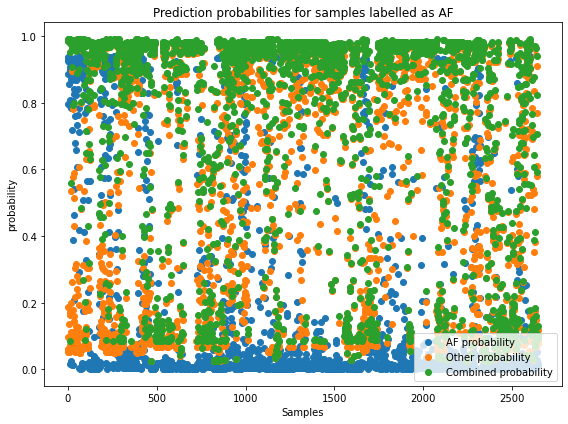

In [8]:
y_a = np.array(feas1_predictions_df.A_probability.to_list())
y_o = np.array(feas1_predictions_df.O_probability.to_list())
x = np.arange(max(y_a.size, y_o.size))  

plt.figure(figsize=(8, 6))

plt.scatter(x, y_a, label="AF probability")
plt.scatter(x, y_o, label="Other probability")
plt.scatter(x, y_a+y_o, label= "Combined probability")
plt.legend(loc="lower right")
plt.ylabel("probability")
plt.xlabel("Samples")
plt.title("Prediction probabilities for samples labelled as AF")
plt.tight_layout()

Clearly a combination of both AF and other lead to a greater likelihood of an AF sample having a high predicted probability

In [56]:
# create an array of probabilities of AF predicted, with the labels for that sample
A_probabilities_and_labels_arr = np.zeros((feas1_predictions_df.shape[0] + len(rows_to_drop), 2), dtype=object)

for index in feas1_predictions_df.index:
    A_prob, label = feas1_predictions_df.loc[index, ["A_probability", "Label"]]
    A_probabilities_and_labels_arr[index,0] = A_prob
    A_probabilities_and_labels_arr[index,1] = label

# delete rows which are ignored because they were removed from df as no label found of use
arr_rows_to_delete = []
for i,label in enumerate(A_probabilities_and_labels_arr.T[1]):
    if label == 0:
        arr_rows_to_delete.append(i)
A_probabilities_and_labels_arr = np.delete(A_probabilities_and_labels_arr, arr_rows_to_delete, 0)
A_probabilities_and_labels_arr

array([[0.8864, 'A'],
       [0.9257, 'A'],
       [0.7969, 'A'],
       ...,
       [0.0152, 'N'],
       [0.0111, 'N'],
       [0.0157, 'N']], dtype=object)

Text(0.5, 1.0, 'Model prediction probabilities of all labelled samples Feas1')

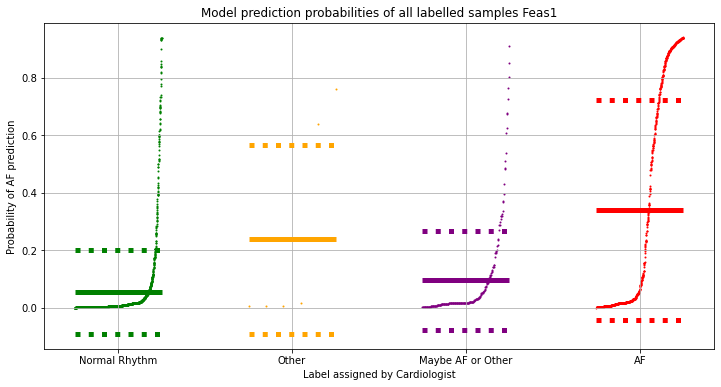

In [132]:
# assigns colour codes and x values for plotting
colour_code_dict = {"A":"r", "O":"orange", "N":"g", "~":"grey", "Maybe A":"purple"}
x_dict_for_class = {"N":0,"O":1, "Maybe A":2, "A":3}
x_dict_for_class_inv = {0:"N", 1:"O", 2:"Maybe A", 3:"A"}

for i in range(int(A_probabilities_and_labels_arr.size/2)):
    if A_probabilities_and_labels_arr[i][1] == "None":
        print(A_probabilities_and_labels_arr[i], i)

# divide data into different classes defined by labels
af_data = A_probabilities_and_labels_arr[A_probabilities_and_labels_arr.T[1]=="A"] 
other_data = A_probabilities_and_labels_arr[A_probabilities_and_labels_arr.T[1] == "O"] 
normal_data = A_probabilities_and_labels_arr[A_probabilities_and_labels_arr.T[1] == "N"] 
maybe_af_data = A_probabilities_and_labels_arr[A_probabilities_and_labels_arr.T[1] == "Maybe A"] 


_index_to_label = {0:"A", 1:"O", 2:"N", 3:"Maybe A"} 
fig, ax = plt.subplots(figsize=(12, 6))
tick_location = []

for i,data_ in enumerate([af_data, other_data, normal_data, maybe_af_data]):
    
    #plot the scatter points
    label_ = _index_to_label[i]
    colour = colour_code_dict[label_]
    data_ = np.sort(data_,0)
    offset_arr = np.linspace(0,0.5,data_.shape[0])
    x_ = np.array([x_dict_for_class[label_]]*data_.shape[0]) + offset_arr
    y_ = data_.T[0]
    ax.scatter(x_,y_,color=colour,s=1)
    tick_location.append(np.mean(x_))
    
    #plot the averages and quartile ranges
    mean_ = np.mean(y_)
    std_ = np.std(y_)
    ax.hlines(mean_,x_[0], x_[-1],color=colour, linewidth=5)
    ax.hlines(mean_+std_,x_[0], x_[-1],color=colour, linestyle="dotted", linewidth=5)
    ax.hlines(mean_-std_,x_[0], x_[-1],color=colour, linestyle="dotted", linewidth=5)
    

ax.grid()
tick_location.sort()
ax.set_xticks(tick_location)
ax.set_xticklabels(["Normal Rhythm", "Other", "Maybe AF or Other", "AF"])
ax.set_ylabel("Probability of AF prediction")
ax.set_xlabel("Label assigned by Cardiologist")
ax.set_title("Model prediction probabilities of all labelled samples Feas1")